In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os

In [2]:
BASE_PATH = '../input/satellite-image-classification/data'

In [3]:
labels = ['CLOUDY', 'DESERT', 'GREEN AREA', 'WATER']
image_list = ['/cloudy/train_10021.jpg', '/desert/desert(1).jpg', 
              '/green_area/Forest_1404.jpg', '/water/SeaLake_1.jpg']
images = [BASE_PATH + image for image in image_list]
images

['../input/satellite-image-classification/data/cloudy/train_10021.jpg',
 '../input/satellite-image-classification/data/desert/desert(1).jpg',
 '../input/satellite-image-classification/data/green_area/Forest_1404.jpg',
 '../input/satellite-image-classification/data/water/SeaLake_1.jpg']

In [4]:
img = cv2.imread(images[1])
img.shape

(256, 256, 3)

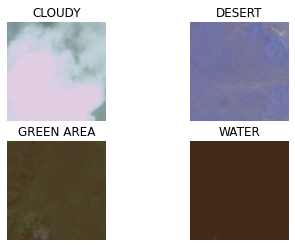

In [5]:
for index, image in enumerate(images):
        plt.subplot(2,2,index+1)
        img = cv2.imread(image)
        plt.imshow(img.astype("uint8"))
        plt.title(labels[index])
        plt.axis("off")
plt.show()

In [6]:
class_folder_paths = [BASE_PATH + '/' + x for x in os.listdir(BASE_PATH + '/')]
class_folder_paths

['../input/satellite-image-classification/data/cloudy',
 '../input/satellite-image-classification/data/desert',
 '../input/satellite-image-classification/data/green_area',
 '../input/satellite-image-classification/data/water']

In [7]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential

In [8]:
IMAGE_SIZE = [255, 255]

In [9]:
vgg16 = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape= IMAGE_SIZE + [3]
)
vgg16.summary()

2022-05-11 20:23:32.465094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 20:23:32.580896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 20:23:32.581609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 20:23:32.582868: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 255, 255, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 255, 255, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 127, 127, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 127, 127, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 127, 127, 128)     147584    
______________________________________________________________

In [10]:
for layer in vgg16.layers:
    layer.trainable =False

In [11]:
x = Flatten()(vgg16.output)

In [12]:
output = Dense(len(class_folder_paths), activation='softmax')(x)

In [13]:
model = Model(inputs=vgg16.input, outputs=output)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 255, 255, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 255, 255, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 127, 127, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 127, 127, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 127, 127, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 63, 63, 128)       0     

In [15]:
model.compile(
loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy']
)

In [16]:
train_data_gen = ImageDataGenerator(
                    rescale = 1./255,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    validation_split=0.2
)

test_data_gen = ImageDataGenerator(rescale = 1./255)

In [17]:
training_set = train_data_gen.flow_from_directory(
                BASE_PATH,
                target_size = (255, 255),
                batch_size =32,
                class_mode = 'categorical',
                shuffle=True,
                subset='training'
)

Found 4505 images belonging to 4 classes.


In [18]:
test_set = train_data_gen.flow_from_directory(
                BASE_PATH,
                target_size = (255, 255),
                batch_size =32,
                class_mode = 'categorical',
                shuffle=False,
                subset='validation'
)

Found 1126 images belonging to 4 classes.


In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early = EarlyStopping(
                      monitor='val_loss',
                      patience=5,
                      restore_best_weights=True
)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [21]:
import time

In [22]:
start_time = time.time()
EPOCHS = 20
model_trained = model.fit(
        training_set,
        validation_data = test_set,
        steps_per_epoch=len(training_set),
        validation_steps=len(test_set),
        callbacks = [early, model_checkpoint_callback], 
        epochs = EPOCHS
)

end_time = time.time()

2022-05-11 20:23:41.590670: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-05-11 20:23:43.616263: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


141/141 [==============================] - 117s 756ms/step - loss: 0.6499 - accuracy: 0.8078 - val_loss: 0.3415 - val_accuracy: 0.9121
Epoch 2/20
141/141 [==============================] - 84s 594ms/step - loss: 0.2291 - accuracy: 0.9458 - val_loss: 0.1933 - val_accuracy: 0.9458
Epoch 3/20
141/141 [==============================] - 83s 590ms/step - loss: 0.1648 - accuracy: 0.9580 - val_loss: 0.1656 - val_accuracy: 0.9538
Epoch 4/20
141/141 [==============================] - 86s 607ms/step - loss: 0.1246 - accuracy: 0.9651 - val_loss: 0.1369 - val_accuracy: 0.9565
Epoch 5/20
141/141 [==============================] - 83s 587ms/step - loss: 0.1148 - accuracy: 0.9676 - val_loss: 0.1203 - val_accuracy: 0.9689
Epoch 6/20
141/141 [==============================] - 85s 604ms/step - loss: 0.1021 - accuracy: 0.9714 - val_loss: 0.1129 - val_accuracy: 0.9698
Epoch 7/20
141/141 [==============================] - 84s 597ms/step - loss: 0.0975 - accuracy: 0.9700 - val_loss: 0.1044 - val_accuracy: 0.

In [23]:

time_elapsed = end_time - start_time
time_elapsed

1930.636801958084

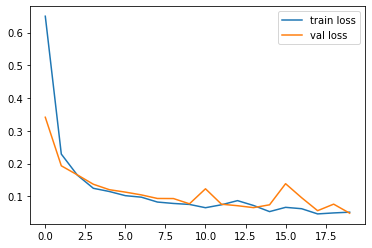

<Figure size 432x288 with 0 Axes>

In [24]:
plt.plot(model_trained.history['loss'], label = 'train loss')
plt.plot(model_trained.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()
plt.savefig('train-val-loss')

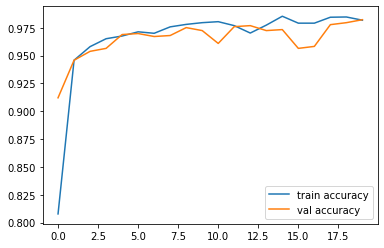

<Figure size 432x288 with 0 Axes>

In [25]:
plt.plot(model_trained.history['accuracy'], label = 'train accuracy')
plt.plot(model_trained.history['val_accuracy'], label = 'val accuracy')
plt.legend()
plt.show()
plt.savefig('train-val-accuracy')

In [26]:
model.load_weights(checkpoint_filepath)

In [27]:
model.evaluate(test_set)

36/36 [==============================] - 17s 464ms/step - loss: 0.0435 - accuracy: 0.9858


[0.0434863455593586, 0.9857904314994812]

In [28]:
model.save(f'vgg16-{32} batch-{EPOCHS} epochs-{time_elapsed} elapsed-{time.time()}-model.h5')